# <오늘 할 것>
## 1. 코너 인식
- 1-1. 코너 검출
- 1-2. 중복 검출 해결

## 2. QR 코드 인식
- 2-1. QR 코드 인식
- 2-2. QR 코드 생성
- 2-3. QR 코드 디코딩
- 2-4. Pyzbar

## 3. 코너 인식 심화: ORB
- 3-1 코너점 & 특징값 검출하기
- 3-2 코너점 & 특징값을 활용한 이미지 간 매칭

## 4. 스티칭

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
import scipy.stats as sp
from PIL import ImageFont, ImageDraw, Image

#import imutils
import qrcode
#from pyzbar.pyzbar import decode    #qr코드 패키지(opencv에도 있지만 성능이 안 좋다)
from bokeh.plotting import figure
from bokeh.io import output_notebook, show, push_notebook

#ouput_notebook()

def imshow(tit, image) :
    plt.title(tit)    
    if len(image.shape) == 3 :
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    else :
        plt.imshow(image, cmap="gray")
    plt.show()
    
    
def create_win(frames, scale=1.0) :    
    global myImage
    
    all = []
    for f in frames :
        if len(f.shape ) !=  3 : f = cv2.cvtColor(f, cv2.COLOR_GRAY2BGR)
        all.append(f)
    frame = np.vstack(all)
    
    fr=cv2.cvtColor(frame, cv2.COLOR_BGR2RGBA) # because Bokeh expects a RGBA image
    fr=cv2.flip(fr, -1) # because Bokeh flips vertically
    width=fr.shape[1]
    height=fr.shape[0]    

    p = figure(x_range=(0,width), y_range=(0,height), output_backend="webgl", width=int(width*scale), height=int(height*scale))    
    myImage = p.image_rgba(image=[fr], x=0, y=0, dw=width, dh=height)
    show(p, notebook_handle=True)   
    
    
def update_win(frames) :
    
    all = []
    for f in frames :
        if len(f.shape ) !=  3 : f = cv2.cvtColor(f, cv2.COLOR_GRAY2BGR)
        all.append(f)
    frame = np.vstack(all)
    
    fr=cv2.cvtColor(frame, cv2.COLOR_BGR2RGBA)
    fr=cv2.flip(fr, -1)
    myImage.data_source.data['image']=[fr]
    push_notebook()
    time.sleep(0.05)

자바와 자바스크립트의 차이는 햄과 햄스터의 차이

# `cornerHarris`
> 코너 찾는 메소드

- 리턴값은 이미지
- cv2.cornerHarris(이미지, 블럭크기, 소벨필터크기, 가중치)
    - 이미지: **그레이스케일**!!!!!!!
    - 블럭크기: 보통 3; 3by3 필터로 계산하겠다는 뜻
    - 소벨필터: 수직, 수평 엣지를 찾는 필터; 보통 3
    - 가중치: 보통 0.04~0.06

In [94]:
src = cv2.imread('building.jpg', cv2.IMREAD_GRAYSCALE)

#  block 크기, 소벨크기,    k=0.04~0.06     R=Det() - kTr()
harris = cv2.cornerHarris(src, 3, 3, 0.04)
print(harris.dtype)
print(harris.shape)   
print('-------------------------------------')
print(harris)
print('-------------------------------------')
print(np.min(harris))
print(np.max(harris)) 

float32
(600, 868)
-------------------------------------
[[ 6.3535038e-11  3.9825465e-10  1.1062862e-09 ...  3.4808958e-10
   2.2088404e-11  1.0773762e-11]
 [ 5.5882576e-10  8.2385315e-10  1.4708644e-09 ...  6.2124239e-10
   1.7738422e-11  8.5010117e-11]
 [ 6.1618904e-11  4.2587414e-10  5.8720817e-10 ...  2.0738461e-10
  -3.8780326e-11 -9.1068139e-11]
 ...
 [ 1.7565064e-08  6.8799721e-09 -4.7442470e-08 ...  1.6815744e-07
  -8.9175529e-09 -7.0084232e-09]
 [-5.2044825e-08 -4.4564167e-08 -4.8254844e-08 ...  2.7257241e-07
  -7.8746627e-09 -6.3438756e-09]
 [-7.3713522e-08 -5.3394622e-08 -3.6134686e-08 ...  4.1195358e-07
  -1.5567483e-08 -1.3638399e-08]]
-------------------------------------
-0.005183762
0.010007294


- uint8이 아니라 float type으로 변환됨
- 2차원 영상임
- harris나 최소/최대값을 출력해봤자무슨 뜻인지 직관적으로 알 수 없다.
- 이럴때는 히스토그램을 그려본다.

(array([8.70000e+01, 4.70000e+02, 7.58900e+03, 5.10984e+05, 1.43100e+03,
        1.69000e+02, 5.10000e+01, 1.30000e+01, 4.00000e+00, 2.00000e+00]),
 array([-0.00518376, -0.00366466, -0.00214555, -0.00062645,  0.00089266,
         0.00241177,  0.00393087,  0.00544998,  0.00696908,  0.00848819,
         0.01000729], dtype=float32),
 <a list of 10 Patch objects>)

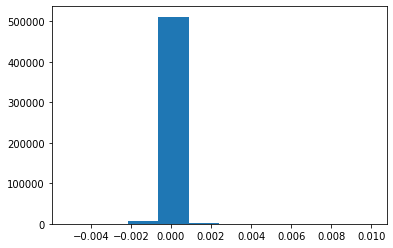

In [3]:
plt.hist(harris.ravel())

- 0 부근에 값이 몰려있음
- 음수값이 있기 때문에 정규화해줘야 한다

uint8


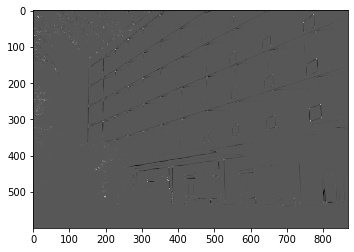

In [4]:
#정규화
harris_norm = cv2.normalize(harris, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)  #uint8로 만들어라

print(harris_norm.dtype)
imshow("", harris_norm)

- uint8 형태로 리턴된다
- 흰색 점들이 harris 변환 시 높은 값이 나온 것들 --> 코너일 확률이 높은 것들

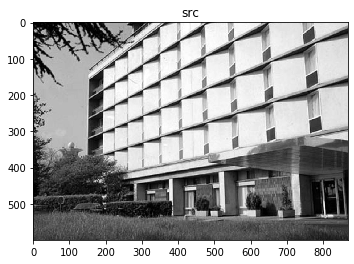

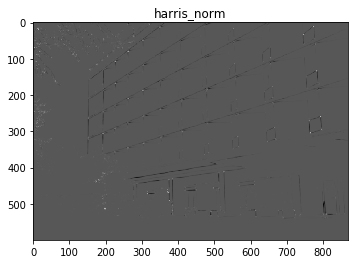

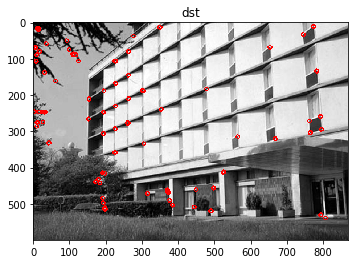

In [5]:
dst = cv2.cvtColor(src, cv2.COLOR_GRAY2BGR)

for y in range(harris_norm.shape[0]):
        for x in range(harris_norm.shape[1]):
            if harris_norm[y, x] > 128:      #128보다 큰 곳에 동그라미를 그린다
                    cv2.circle(dst, (x, y), 5, (0, 0, 255), 2)

#모든 방향(수평, 수직, 대각 등)으로 주변보다 밝거나 어두워야 코너로 본다 --> 그래서 인간과 기계의 코너가 다름

imshow('src', src)
imshow('harris_norm', harris_norm)
imshow('dst', dst)

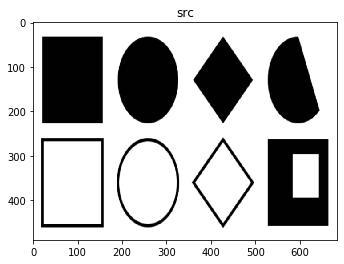

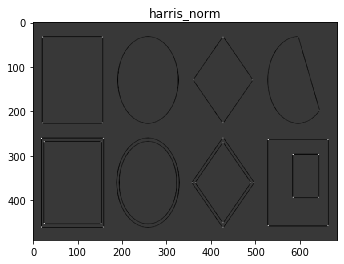

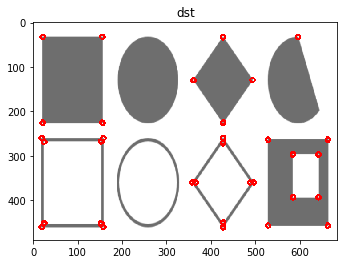

In [6]:
#다른 이미지로도 해본다.
src = cv2.imread('corner.png', cv2.IMREAD_GRAYSCALE)

#harris 변환
harris = cv2.cornerHarris(src, 3, 3, 0.04)

#정규화
harris_norm = cv2.normalize(harris, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)

dst = cv2.cvtColor(src, cv2.COLOR_GRAY2BGR)

for y in range(harris_norm.shape[0]):
        for x in range(harris_norm.shape[1]):
            if harris_norm[y, x] > 70:
                    cv2.circle(dst, (x, y), 5, (0, 0, 255), 2)


imshow('src', src)
imshow('harris_norm', harris_norm)
imshow('dst', dst)

지난 번에도 꼭짓점 찾기를 했었다.
- 그 때는 엣지를 찾은 후 점의 변화량을 기준으로 approximate하여 찾는 방식
- 이번에는 직접적으로 꼭짓점을 찾는 방식

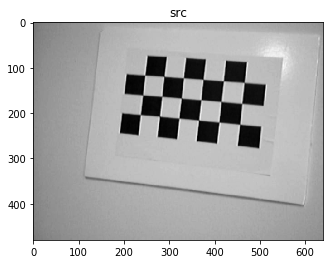

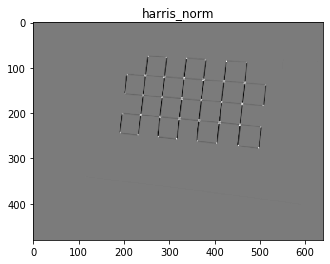

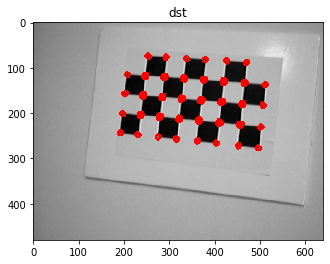

In [7]:
#다른 이미지로도 해본다. 2
src = cv2.imread('chessBoard.jpg', cv2.IMREAD_GRAYSCALE)

#harris 변환
harris = cv2.cornerHarris(src, 3, 3, 0.04)

#정규화
harris_norm = cv2.normalize(harris, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)

dst = cv2.cvtColor(src, cv2.COLOR_GRAY2BGR)

for y in range(harris_norm.shape[0]):
        for x in range(harris_norm.shape[1]):
            if harris_norm[y, x] > 128:
                    cv2.circle(dst, (x, y), 5, (0, 0, 255), 2)


imshow('src', src)
imshow('harris_norm', harris_norm)
imshow('dst', dst)

## 블러링 후 코너인식

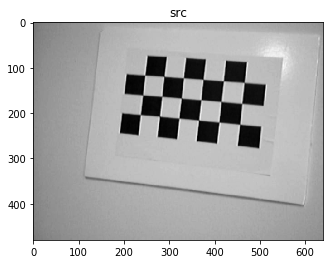

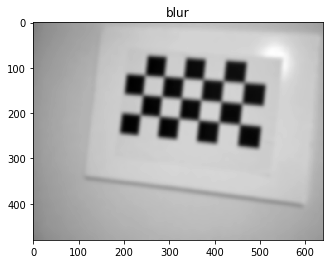

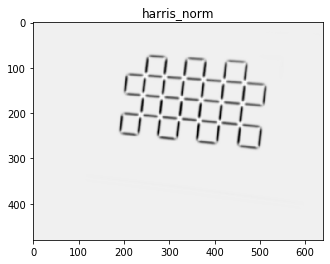

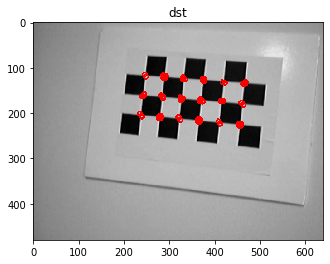

In [8]:
#블러링을 하면 어떻게 될까?
src = cv2.imread('chessBoard.jpg', cv2.IMREAD_GRAYSCALE)

blur = cv2.GaussianBlur(src, (25, 25), 0)

#harris 변환
harris = cv2.cornerHarris(blur, 3, 3, 0.04)

#정규화
harris_norm = cv2.normalize(harris, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)

dst = cv2.cvtColor(src, cv2.COLOR_GRAY2BGR)

for y in range(harris_norm.shape[0]):
        for x in range(harris_norm.shape[1]):
            if harris_norm[y, x] > 250:
                    cv2.circle(dst, (x, y), 5, (0, 0, 255), 2)


imshow('src', src)
imshow('blur', blur)
imshow('harris_norm', harris_norm)
imshow('dst', dst)

블러가 어느정도 되어도 코너를 찾을 수 있다

--> 영상이 그다지 또렷하지 않아도 QR코드가 인식될 것이라는 것을 의미한다

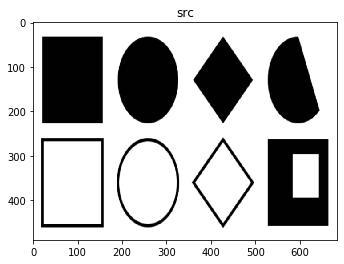

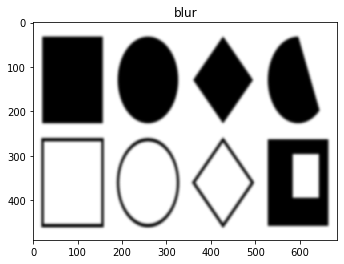

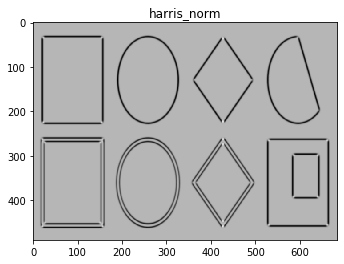

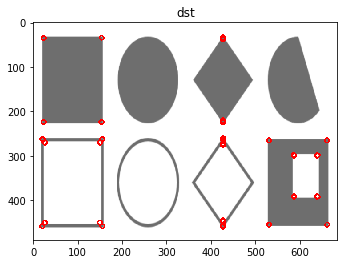

In [9]:
#다른 이미지로도 해본다.
src = cv2.imread('corner.png', cv2.IMREAD_GRAYSCALE)

blur = cv2.GaussianBlur(src, (15, 15), 0)

#harris 변환
harris = cv2.cornerHarris(blur, 3, 3, 0.04)

#정규화
harris_norm = cv2.normalize(harris, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)

dst = cv2.cvtColor(src, cv2.COLOR_GRAY2BGR)

for y in range(harris_norm.shape[0]):
        for x in range(harris_norm.shape[1]):
            if harris_norm[y, x] > 200:
                    cv2.circle(dst, (x, y), 5, (0, 0, 255), 2)


imshow('src', src)
imshow('blur', blur)
imshow('harris_norm', harris_norm)
imshow('dst', dst)

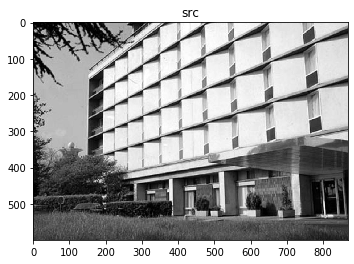

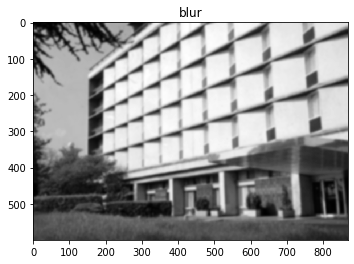

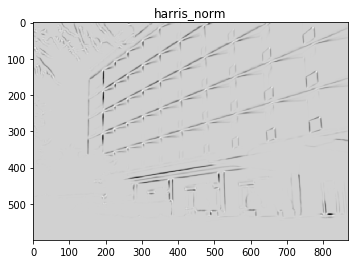

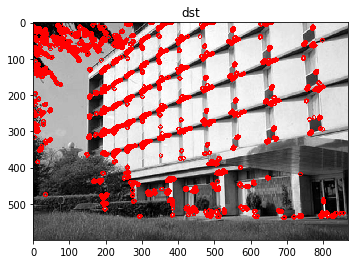

In [10]:
#다른 이미지로도 해본다.
src = cv2.imread('building.jpg', cv2.IMREAD_GRAYSCALE)

blur = cv2.GaussianBlur(src, (15, 15), 0)

#harris 변환
harris = cv2.cornerHarris(blur, 3, 3, 0.04)

#정규화
harris_norm = cv2.normalize(harris, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)

dst = cv2.cvtColor(src, cv2.COLOR_GRAY2BGR)

for y in range(harris_norm.shape[0]):
        for x in range(harris_norm.shape[1]):
            if harris_norm[y, x] > 210:
                    cv2.circle(dst, (x, y), 5, (0, 0, 255), 2)


imshow('src', src)
imshow('blur', blur)
imshow('harris_norm', harris_norm)
imshow('dst', dst)

# for 문을 없애보자

- 컴파일러 언어(C 등)가 아닌 이상 for문이 많아질수록 cost가 커진다.
    - C는 for문과 속도 관계 별로 없다.
    
- **넘파이의 마스킹 기능**을 활용해서 위의 프로세스에서 for문을 없앨 수 있다.

### <넘파이 마스킹 이해하기>

In [11]:
a = np.array([[1, 2, 4], [7, 0, 1]])
print(a)
b = a > 3   # 원소 by 원소로 조건을 적용하여 True/False를 원소로 하는 새로운 넘파이 객체 리턴
print(b)
a[b] = 100  # 마스킹:False는 원래값, True는 새로 지정한 값(100)으로 변환
print(a)

[[1 2 4]
 [7 0 1]]
[[False False  True]
 [ True False False]]
[[  1   2 100]
 [100   0   1]]


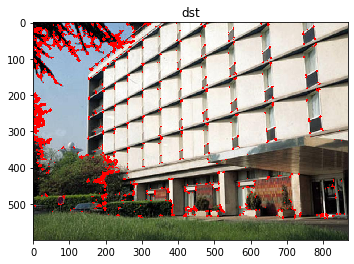

In [12]:
gray = cv2.imread('building.jpg', 0)
dst = cv2.cornerHarris(gray, 5, 3, 0.04)
img = cv2.imread('building.jpg')
img[dst > 0.01 * dst.max()] = [0, 0, 255]  #넘파이라서 이러한 표현 가능; 픽셀 값이 최댓값의 1퍼센트 이상이라면 [0, 0, 255]로 변환
imshow('dst', img)

Harris Corner는 편리하지만 내부 수식이 매우 복잡하다.

좋은 특징점이란?: **여러 방향**으로 밝기 변화가 나타나는 지점

Harris Corner의 알고리즘

모라벡 알고리즘
자신을 중심으로 주변의 모든 점과 한번 빼본다 --> 모든 방향으로의 밝기변화를 측정


# `FastFeatureDetector_create`
- 속도가 빠름
    - 코너점만 찾아낸다.
    - cornerHarris보다 성능은 좀 떨어진다.
- 디텍터 객체를 리턴함
    - 생성한 디텍터에 `detect`메소드를 적용하여 코너점을 검출할 수 있다.
        - 코너점(리스트)을 리턴한다.
    - fast = cv2.FastFeatureDetector_create(값)
    - keypoints = fast.detect(이미지)
- cv2.FastFeatureDetector_create(값)
    - 값: 작아질수록 많은 점 검출; 원에서도 검출되지만 중첩되어서 검출될수 있다.

In [96]:
src = cv2.imread('chessBoard.jpg', cv2.IMREAD_GRAYSCALE)
#src = cv2.imread('corner.png', cv2.IMREAD_GRAYSCALE)

fast = cv2.FastFeatureDetector_create(50)
keypoints = fast.detect(src)    #특징점의 리스트
print(len(keypoints))           #특징점의 개수
print(type(keypoints[0]))       #데이터타입은 Keypoint 객체
print(keypoints[0].pt)          #0번째 코너의 좌표점; .pt: 좌표점을 리턴하는 메소드
print(type(keypoints[0].pt))    #데이터타입은 튜플임

92
<class 'cv2.KeyPoint'>
(254.0, 75.0)
<class 'tuple'>


코너는 40개인데 keypoint는 92개가 검출됨
(중복검출되었기 때문)

--> 어떻게 해야할까?

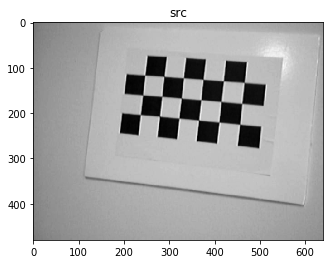

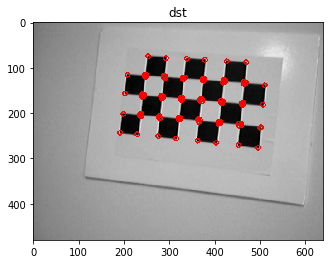

In [14]:
dst = cv2.cvtColor(src, cv2.COLOR_GRAY2BGR)

for kp in keypoints:
    pt = (int(kp.pt[0]), int(kp.pt[1]))   #circle메소드는 int만 받기 때문에 타입변환 해준다
    cv2.circle(dst, pt, 5, (0, 0, 255), 2)

imshow('src', src)
imshow('dst', dst)

# 1-2. 중첩 검출 해결

1. 중첩된 점을 확실히 중첩시켜서(원 굵기 조절)

2. 컨투어 따고

3. 중심점을 구해서

4. 그 점으로 통일시킨다

(480, 640)


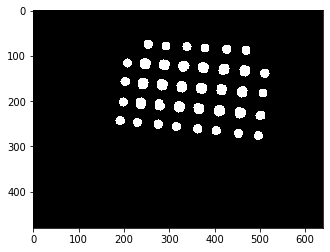

In [15]:
#확실히 중첩시키기
mask = np.zeros( src.shape , dtype = 'uint8')
print(mask.shape)
for kp in keypoints:
    pt = (int(kp.pt[0]), int(kp.pt[1]))   #circle메소드는 int만 받기 때문에 타입변환 해준다
    cv2.circle(mask, pt, 10, (255, 255, 255), -1)  #원 굵기를 키워서 확실히 중첩되도록

imshow("", mask)

In [16]:
#컨투어 따기
contours, _ = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

# `moments`
- 중심점을 구하는 메소드
- 딕셔너리를 리턴한다
- cv2.moments(컨투어, 폐곡선 여부)

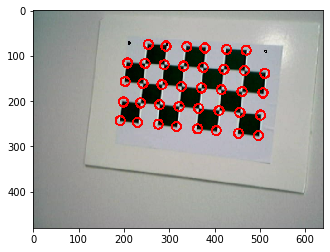

[[497, 276], [453, 271], [404, 265], [363, 261], [316, 256], [276, 251], [230, 247], [192, 243], [502, 231], [456, 225], [410, 221], [365, 216], [322, 212], [279, 208], [237, 204], [199, 202], [507, 182], [461, 179], [415, 175], [371, 171], [327, 168], [284, 164], [242, 161], [203, 157], [511, 139], [466, 133], [421, 130], [375, 126], [332, 123], [289, 120], [208, 116], [247, 117], [470, 88], [427, 86], [379, 83], [339, 80], [293, 79], [254, 75]]
38


In [17]:
#중심점 구하기
src = cv2.imread('chessboard2.jpg')
points = []
for con in contours:
    M = cv2.moments(con, True)
    #print(M)
    cx = int(M['m10'] / M['m00'])   #m10: x축들을 다 더한 것; m00: 면적 == 점 개수
    cy = int(M['m01'] / M['m00'])   #m01: y축들을 다 더한 것;
    cv2.circle(src, (cx, cy), 10, (0, 0, 255), 3)
    points.append([cx, cy])
imshow("", src)
print(points)
print(len(points))

점의 순서는 랜덤이다.

--> 점을 정렬할 수 있을까?

hint: lambda expression

hint: 일단 y 좌표로 정렬

hint: 그 다음에 x 좌표로 정렬

# 2. QR 코드
## 2-1. QR 코드 인식

0


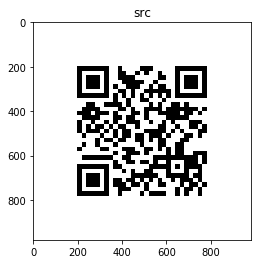

In [18]:
src = cv2.imread('acronet.png')
gray = cv2.imread('acronet.png', cv2.IMREAD_GRAYSCALE)

fast = cv2.FastFeatureDetector_create(50)
keypoints = fast.detect(gray)
print(len(keypoints))

for kp in keypoints:
    pt = (int(kp.pt[0]), int(kp.pt[1]))   #circle메소드는 int만 받기 때문에 타입변환 해준다
    cv2.circle(src, pt, 5, (0, 0, 255), 2)

imshow('src', src)

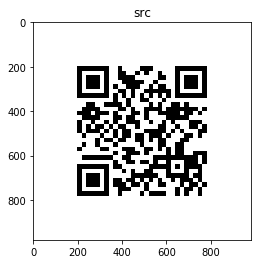

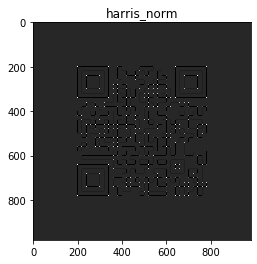

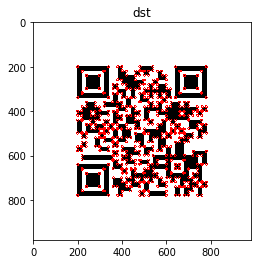

In [19]:
src = cv2.imread('acronet.png', cv2.IMREAD_GRAYSCALE)

#harris 변환
harris = cv2.cornerHarris(src, 3, 3, 0.04)

#정규화
harris_norm = cv2.normalize(harris, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)

dst = cv2.cvtColor(src, cv2.COLOR_GRAY2BGR)

for y in range(harris_norm.shape[0]):
        for x in range(harris_norm.shape[1]):
            if harris_norm[y, x] > 128:
                    cv2.circle(dst, (x, y), 5, (0, 0, 255), 2)


imshow('src', src)
imshow('harris_norm', harris_norm)
imshow('dst', dst)

코너가 깔끔하게 검출된다.

## 2-2 QR 코드 생성

# `QRCode`
- QR코드 생성하는 메소드
- qr = qrcode.QRCode(version = , error_correction = , box_size = , border = )
    - version: 2
    - error_correction: qrcode.constants.ERROR_CORRECT_H
    - url 더하기: qr.add_data(url)
    - qr 만들기: qr.make()
    - 이미지로 만들기: qr.make_image(fill_color = , back_color = )

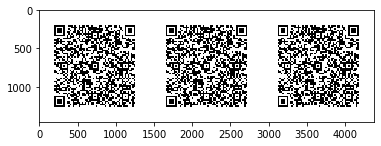

In [20]:
#pip install qrcode
#import qrcode

#QR코드 생성
qr = qrcode.QRCode(version = 2,
     error_correction = qrcode.constants.ERROR_CORRECT_H,
     box_size = 20,
     border = 10)

#url 연결
url = 'https://search.naver.com/search.naver?sm=top_hty&fbm=0&ie=utf8&query=%EB%82%A0%EC%94%A8'
#url = 'bumlam.blogspot.com'
qr.add_data(url)
qr.make()

#이미지로 생성; 어차피 인식 후 내부적으로 바이너리로 디코딩하기 때문에 색상은 원하는대로 줘도 됨(흑백만 가능한 것 아님
img = qr.make_image(fill_color="black", back_color="white")

plt.imshow(img, cmap="gray")

img.save("qrcode.png")

img = cv2.imread("qrcode.png")
img = np.hstack([img, img, img])
cv2.imwrite("3.png", img)
imshow("", img)

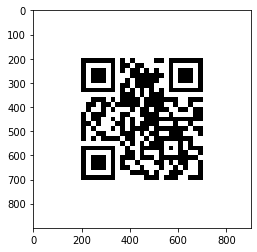

In [21]:
#pip install qrcode
#import qrcode

#QR코드 생성
qr = qrcode.QRCode(version = 2,
     error_correction = qrcode.constants.ERROR_CORRECT_H,
     box_size = 20,
     border = 10)

#데이터 더하기
qr.add_data("hello world!")
qr.make()

#이미지로 생성; 어차피 인식 후 내부적으로 바이너리로 디코딩하기 때문에 색상은 원하는대로 줘도 됨(흑백만 가능한 것 아님
img = qr.make_image(fill_color="black", back_color="white")

plt.imshow(img, cmap="gray")

img.save("qrcode2.png")

그냥 텍스트를 인코딩하면, 생성된 QR코드를 인식했을 때, 해당 텍스트를 키워드로 구글 검색 결과 페이지로 연결된다.

## 2-3 QR 디코딩

# `QRCodeDetector`
- QR 코드 디코더를 생성하는 메소드이다.
- qrDecoder = cv2.QRCodeDetector()
    - `detectAndDecode` 메소드로 QR코드를 인식하고 디코딩할 수 있다.
        - QR 코드를 디코딩하는 메소드이다.
        - qrDecoder.detectAndDecode(이미지)
        - 세가지 값을 리턴한다.
            - data: qr.add_data로 더한 자료
            - bbox: bounding box; QR이 있는 위치(좌표)
            - rectifiedImage: QR만 네모나게 잘라진 이미지

https://search.naver.com/search.naver?sm=top_hty&fbm=0&ie=utf8&query=%EB%82%A0%EC%94%A8


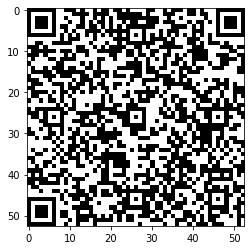

In [22]:
image = cv2.imread('qrcode.png')
qrDecoder = cv2.QRCodeDetector()
data, bbox, rectifiedImage = qrDecoder.detectAndDecode(image)

print(data)

imshow("", rectifiedImage)

C190000005169|31097


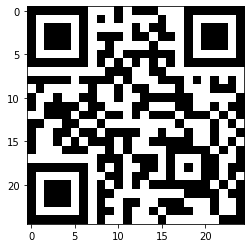

In [23]:
#멀티캠퍼스 출입 QR이미지로 해본다.
image = cv2.imread('IMG_7116.PNG')
qrDecoder = cv2.QRCodeDetector()
data, bbox, rectifiedImage = qrDecoder.detectAndDecode(image)

print(data)

imshow("", rectifiedImage)

교육생별 고유 ID가 인코딩되어 있음을 확인할 수 있다.

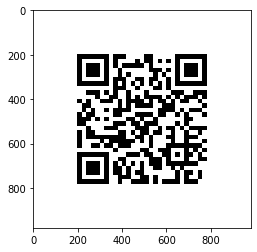

In [24]:
qr = qrcode.QRCode(version = 2, error_correction = qrcode.constants.ERROR_CORRECT_H, box_size=20, border=10)

qr.add_data('C190000005169|31097')

qr.make()

img = qr.make_image(fill_color = 'black', back_color = 'white')

plt.imshow(img, cmap = 'gray')

## cf. QR 오류 실험

https://search.naver.com/search.naver?sm=top_hty&fbm=0&ie=utf8&query=%EB%82%A0%EC%94%A8


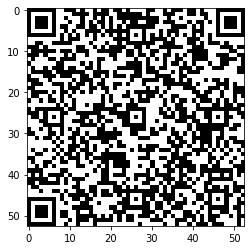

In [25]:
#위에서 생성했던 네이버 날씨 QR의 일부를 그림판으로 제거한 후 디코딩 시도
image = cv2.imread('qrcode.png')
qrDecoder = cv2.QRCodeDetector()
data, bbox, rectifiedImage = qrDecoder.detectAndDecode(image)

print(data)

imshow("", rectifiedImage)

링크가 제대로 출력된다.

https://search.naver.com/search.naver?sm=top_hty&fbm=0&ie=utf8&query=%EB%82%A0%EC%94%A8


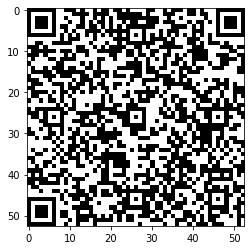

In [26]:
#좀 더 삭제하고 다시 디코딩 시도
image = cv2.imread('qrcode.png')
qrDecoder = cv2.QRCodeDetector()
data, bbox, rectifiedImage = qrDecoder.detectAndDecode(image)

print(data)

imshow("", rectifiedImage)

여전히 잘 출력된다.

https://search.naver.com/search.naver?sm=top_hty&fbm=0&ie=utf8&query=%EB%82%A0%EC%94%A8


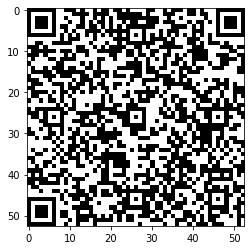

In [27]:
#조금만 더 삭제하고 다시 디코딩 시도
image = cv2.imread('qrcode.png')
qrDecoder = cv2.QRCodeDetector()
data, bbox, rectifiedImage = qrDecoder.detectAndDecode(image)

print(data)

imshow("", rectifiedImage)

오...아직 잘 된다....

## 2-4. Pyzbar

[Decoded(data=b'https://search.naver.com/search.naver?sm=top_hty&fbm=0&ie=utf8&query=%EB%82%A0%EC%94%A8', type='QRCODE', rect=Rect(left=198, top=198, width=1062, height=1062), polygon=[Point(x=198, y=198), Point(x=203, y=1259), Point(x=1260, y=1260), Point(x=1258, y=204)])]


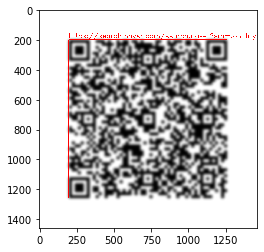

In [45]:
#pip install pyzbar; qr, 바코드 모두 인식 가능한 라이브러리
#Visual C 설치해야 함: https://visualstudio.microsoft.com/ko/downloads/
#Community 버전 받으면 됨
from pyzbar.pyzbar import decode

image = cv2.imread('qrcode.png')
image = cv2.GaussianBlur(image, (61,61), 0)  #어디까지 가능한지 테스트
#image = cv2.imread('barqr.jpg')
code = decode(image)
print(code)

for barcode in code:
    (x, y, w, h) = barcode.rect
    cv2.rectangle(image, (x, y), (x + w, y + h), (0, 0, 255), 2)
 
    barcodeData = barcode.data.decode("utf-8")
    barcodeType = barcode.type
 
    text = "{} ({})".format(barcodeData, barcodeType)
    cv2.putText(image, text, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX,
        1.5, (0, 0, 255), 2) 
imshow("", image)

블러링을 정말 많이 해도 qr 인식이 가능하다. 이것이 바로 opencv 내장 QRCodeDetector와의 성능차이다.

+ OCR보다 QR 인식이 더 실용적인 이유이기도 하다.

# 3. 코너 인식 심화: ORB

## 3-1 코너점 & 특징값 검출하기

# `ORB_create()`
> 코너점 및 특징값을 추출하는 orb 객체를 생성하는 메소드

orb = cv2.ORB_create()

- `detect` 메소드로 코너를 검출할 수 있다.
    - Keypoints 타입으로 구성된 리스트를 리턴한다.
    - keypoints = orb.detect(이미지(그레이))
- `compute` 메소드로 코너점별 특징값을 추출할 수 있다.
    - keypoints와 특징값을 리턴한다.
    - keypoints, desc = orb.comput(이미지, 키포인트)
- 두 메소드를 `orb.detectAndCompute(이미지, None)`으로 합쳐서 쓸 수도 있다.
    
# `drawKeypoints`
> 코너점 및 특징값을 그리는 메소드

- 코너/특징값을 그린 이미지를 리턴한다.
- 새 이미지 = cv2.drawKeypoints(이미지, 코너점, None, 색, cv2.DrawMatchesFlags_DRAW_RICH_KEYPOINTS)
    - None:
    - 색: (-1, -1, -1) == 랜덤
    - cv2.DrawMatchesFlags_DRAW_RICH_KEYPOINTS:

len(keypoints): 187
desc.shape: (187, 32)


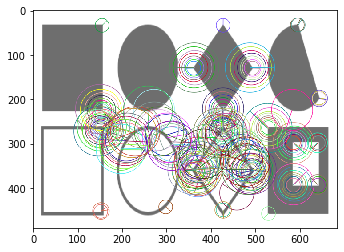

In [65]:
#src = cv2.imread('box_in_scene.png', cv2.IMREAD_GRAYSCALE)
src = cv2.imread('corner.png', cv2.IMREAD_GRAYSCALE)

orb = cv2.ORB_create()
keypoints = orb.detect(src)
keypoints, desc = orb.compute(src, keypoints)   # desc: 코너점별 32바이트짜리 특징값

print('len(keypoints):', len(keypoints))
print('desc.shape:', desc.shape)


dst = cv2.drawKeypoints(src, keypoints, None, (-1, -1, -1),
                       cv2.DrawMatchesFlags_DRAW_RICH_KEYPOINTS)

imshow("", dst)

이게 뭘까?
- 코너당 원 하나씩 그린 것임
    - 직선: 코너의 방향성
    - 동심원: 코너를 찾을 때 참조한 주변 범위

len(keypoints): 20
desc.shape: (187, 32)


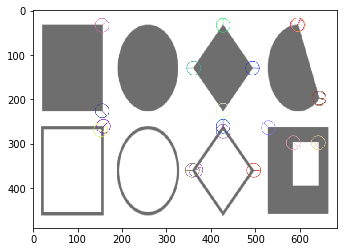

In [61]:
#어지러우니 몇개만 그려본다.
keypoints = keypoints[:20]
print('len(keypoints):', len(keypoints))
print('desc.shape:', desc.shape)


dst = cv2.drawKeypoints(src, keypoints, None, (-1, -1, -1),
                       cv2.DrawMatchesFlags_DRAW_RICH_KEYPOINTS)

imshow("", dst)

len(keypoints): 500
desc.shape: (500, 32)


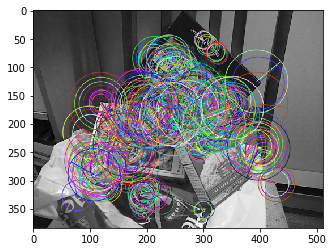

In [62]:
#다른 이미지로도 해본다
src = cv2.imread('box_in_scene.png', cv2.IMREAD_GRAYSCALE)

orb = cv2.ORB_create()
keypoints = orb.detect(src)
keypoints, desc = orb.compute(src, keypoints)   # desc: 코너점별 32바이트짜리 특징값

print('len(keypoints):', len(keypoints))
print('desc.shape:', desc.shape)


dst = cv2.drawKeypoints(src, keypoints, None, (-1, -1, -1),
                       cv2.DrawMatchesFlags_DRAW_RICH_KEYPOINTS)

imshow("", dst)

len(keypoints): 20
desc.shape: (500, 32)


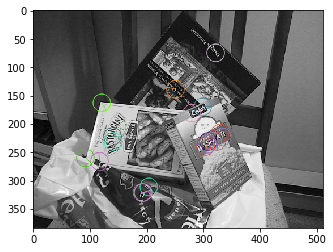

In [66]:
src = cv2.imread('box_in_scene.png', cv2.IMREAD_GRAYSCALE)

orb = cv2.ORB_create()
keypoints = orb.detect(src)
keypoints, desc = orb.compute(src, keypoints)   # desc: 코너점별 32바이트짜리 특징값

keypoints = keypoints[:20]

print('len(keypoints):', len(keypoints))
print('desc.shape:', desc.shape)


dst = cv2.drawKeypoints(src, keypoints, None, (-1, -1, -1),
                       cv2.DrawMatchesFlags_DRAW_RICH_KEYPOINTS)

imshow("", dst)

In [69]:
#0번째 코너점의 특징값
print(desc[0])

[ 93  89 127 161 134  90 182 224 108  96 119 162  95  30 163  41  51 213
 164 243  85 181  45 110 254 167  99  71 229  59  45  71]


위의 특징값들은 회전/이동/조명변화 되더라도 변하지 않는다.

## 3-2 코너점 & 특징값을 활용한 이미지 간 매칭

1. 이미지 읽어오기
2. ORB로 코너점과 특징값 검출하기
3. BFMatcher로 매치 정보 계산하기
4. 매치 정보를 distance로 정렬하기
5. 매치 정보를 그리기

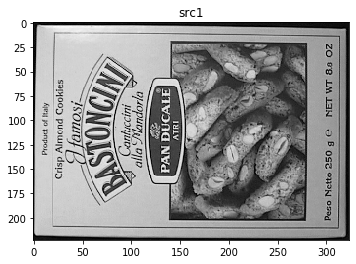

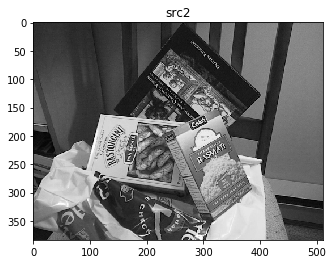

desc1.shape (453, 32)
desc2.shape (500, 32)


In [72]:
#1. 이미지를 읽어오자
src1 = cv2.imread('box.png', cv2.IMREAD_GRAYSCALE)
src2 = cv2.imread('box_in_scene.png', cv2.IMREAD_GRAYSCALE)

imshow("src1", src1)
imshow("src2", src2)

#2. 코너점과 특징값을 검출해보자
orb = cv2.ORB_create()
keypoints1, desc1 = orb.detectAndCompute(src1, None)
keypoints2, desc2 = orb.detectAndCompute(src2, None)

print('desc1.shape', desc1.shape)
print('desc2.shape', desc2.shape)

첫번째 이미지에서 453개, 두번째 이미지에서 500개의 코너점이 검출되었다.

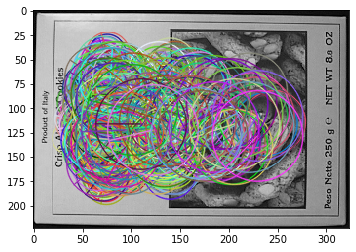

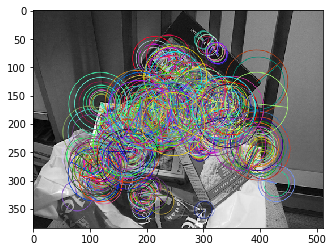

In [76]:
#코너점과 특징값을 그려보자
dst1 = cv2.drawKeypoints(src1, keypoints1, None, (-1, -1, -1), cv2.DrawMatchesFlags_DRAW_RICH_KEYPOINTS)
dst2 = cv2.drawKeypoints(src2, keypoints2, None, (-1, -1, -1), cv2.DrawMatchesFlags_DRAW_RICH_KEYPOINTS)

imshow("", dst1)
imshow("", dst2)

# `BFMatcher_create()`
> matcher 객체를 생성하는 메소드

- 인자로 거리 계산 방법을 전달한다.
    - cv2.NORM_HAMMING
- `match`메소드를 활용하여 match 정보를 계산한다.
    - 리턴값은 DMatch 데이터 타입의 리스트이다.
        - (아래에서 더 자세히 확인한다)
    - matcher객체.match(특징값1, 특징값2)
- opencv의 `drawMatches` 메소드로 match 정보를 그린다.
    - 리턴값은 이미지이다.
    - cv2.drawMatches(이미지1, 코너점1, 이미지2, 코너점2, match 정보, None)

cv2.NORM_HAMMING
> hamming distance로 거리 계산

- 정확한 거리는 아니고, 이진화 후 정보량(비트)의 차이를 계산

e.g. 7 --> 111, 3 --> 11

==> 둘의 차이는 1비트

7과 3의 hamming distance는 1이다.

- 비트연산이기 때문에 고속연산이 가능하다.

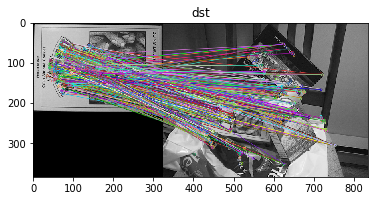

True

In [79]:
#3. 두 이미지를 매칭해보자
matcher = cv2.BFMatcher_create(cv2.NORM_HAMMING)
matches = matcher.match(desc1, desc2)

dst = cv2.drawMatches(src1, keypoints1, src2, keypoints2, matches, None)

imshow('dst', dst)
cv2.imwrite('orb.png', dst)

아이고

In [85]:
print(keypoints1[171].pt)
print(desc1[171])
print('---------------------------------')
print(keypoints2[171].pt)
print(desc2[171])

(56.400001525878906, 134.40000915527344)
[103 153 226  94 193 208  86 176 121  66 254  18 106 254  46 116  93 250
 182 194 221  47 246 227  19  62 144  75 127 173 248  70]
---------------------------------
(121.20000457763672, 297.6000061035156)
[169  30  14  49 184 251 145 119 188 239 246 253 159   6 130 153 206  34
 206  52 189 207  97  12 236 195 122 209 202  76 175 217]


In [83]:
print(len(matches))

453


`DMatch` 클래스
- 세가지 정보를 제공한다.
    - `queryIdx`: 첫번째 이미지에서 점의 인덱스
    - `trainIdx`: 두번째 이미지에서 해당 점과 매치된 점의 인덱스
    - `distance`: 매치된 점 사이의 hamming distance

In [103]:
print(matches[2].queryIdx)     #첫번째 이미지에서 점의 인덱스
print(matches[2].trainIdx)     #두번째 이미지에서 해당 점과 매치된 점의 인덱스
print(matches[2].distance)     #해당 점과 매치된 점 사이의 hamming distance --> 특징값으로 비교하기 때문에 hamming distance가 작을수록 일치도가 높은 것임

2
378
77.0


In [89]:
for m in matches:
    print(f"{m.queryIdx - m.trainIdx / m.distance}")

-5.662790697674419
-3.1643835616438354
-2.909090909090909
-0.7471264367816093
2.4634146341463414
0.8701298701298699
5.2073170731707314
5.636363636363637
1.506849315068493
7.7368421052631575
7.987654320987654
4.578947368421052
5.9324324324324325
10.986486486486486
13.75
9.573170731707318
14.588235294117647
13.647887323943662
16.848837209302324
16.614285714285714
16.121951219512194
17.797619047619047
17.243243243243242
16.87142857142857
23.160493827160494
20.595238095238095
25.05263157894737
26.151898734177216
22.28787878787879
25.63855421686747
23.375
25.826666666666668
30.821428571428573
26.430555555555557
30.91025641025641
28.057142857142857
32.0253164556962
31.166666666666668
35.943661971830984
34.7037037037037
37.220588235294116
32.916666666666664
38.45679012345679
35.892307692307696
42.734939759036145
38.43421052631579
42.642857142857146
44.67088607594937
44.951219512195124
48.130434782608695
47.328947368421055
49.848101265822784
48.16883116883117
52.12820512820513
52.5060240963855

In [92]:
#매치된 점들의 원본 이미지에서의 좌표를 출력해보자
print(keypoints1[matches[0].queryIdx].pt)
print(keypoints2[matches[0].trainIdx].pt)

(83.0, 78.0)
(343.9854736328125, 186.32545471191406)


매치된 두 점의 거리로 정렬하면 **"good_matches"**를 추출할 수 있다.

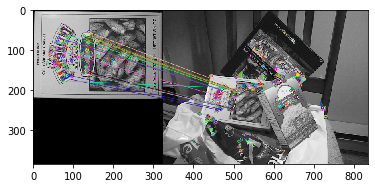

True

In [107]:
#4. 매치 정보를 거리순으로 정렬하자
matches = sorted(matches, key = lambda x: x.distance)
good_matches = matches[:20]

#5. 정렬된 매치 정보를 그려보자
dst2 = cv2.drawMatches(src1, keypoints1, src2, keypoints2, good_matches, None)

imshow("", dst2)
cv2.imwrite("orb2.png", dst2)

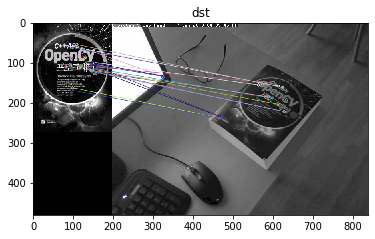

True

In [111]:
#다른 이미지들로 다시 해보기

#1. 이미지 읽어오기
src1 = cv2.imread('book3.jpg', cv2.IMREAD_GRAYSCALE)
src2 = cv2.imread('book3_1.jpg', cv2.IMREAD_GRAYSCALE)

#2. ORB로 코너점과 특징값 검출하기
orb = cv2.ORB_create(50)
keypoints1, desc1 = orb.detectAndCompute(src1, None)
keypoints2, desc2 = orb.detectAndCompute(src2, None)

#3. BFMatcher로 매치 정보 계산하기
matcher = cv2.BFMatcher_create(cv2.NORM_HAMMING)
matches = matcher.match(desc1, desc2)

#4. 매치 정보를 distance로 정렬하기
matches = sorted(matches, key = lambda x: x.distance)
good_matches = matches[:20]

#5. 매치 정보를 그리기
dst = cv2.drawMatches(src1, keypoints1, src2, keypoints2, good_matches, None)
imshow("dst", dst)

#6. 저장하기
cv2.imwrite("book_orb.png", dst)

# 4. 스티칭
> 코너 인식을 활용해서 연속되는 이미지를 이어붙이는 것

# `Stitcher_create()`
> stitcher 객체를 생성하는 메소드

stitcher = cv2.Stitcher_create()

- `stitch` 메소드를 통해 이미지를 이어붙인다.
    - 리턴값은 stauts, 이미지이다.
    - stauts, dst - stitcher.stitch(이미지들)
        - 이미지들: 넘파이 어레이를 원소로 갖는 **리스트** 타입이어야 한다.

In [9]:
files = ['left.jpeg','right.jpeg']

imgs = []

for file in files:
    img = cv2.imread(file)
    imgs.append(img)

In [10]:
stitcher = cv2.Stitcher_create()

In [ ]:
status, dst = stitcher.stitch(imgs)

왜 이렇게 오래 걸려..?

In [ ]:
cv2.imwrite('result.jpg', dst)
imshow('dst', dst)